This code computes the probability of Schwinger pair production by $A_0(t,x)$, $A_0(t,x,y)$ or $A_0(t,x,y,z)$ using the method in:

*Momentum correlation in pair production by spacetime dependent fields from scattered wave functions*

arXiv:2509.17770

G. Torgrimsson


The code has been tested on Colab with 3 different runtime types: CPU for $A_0(t,x)$, T4 GPU for $A_0(t,x,y)$, and A100 GPU for $A_0(t,x,y,z)$.

# Import

diffrax contains the ODE solver for solving the Dirac equation on a GPU.

In [1]:
%%capture output
%pip install diffrax

In [2]:
import jax
import jax.numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson
from scipy.interpolate import make_interp_spline
from tqdm import tqdm
from diffrax import diffeqsolve, ODETerm, Dopri5, Tsit5, PIDController

# Define field and discretization

We assume a gauge field with ${\bf A}=0$ and $A_0(t,x,y,z)$. The field and the scattered wave function should be contained in $-x_b<x,y,z<x_b$. $n_x$ is the number of points in the $x$, $y$ and $z$ directions. $n_k$ ($\geq n_x$) is the number of points in the Fourier space. Both $n_x$ and $n_k$ should be odd.   

In [ ]:
xDim=1; gDim=2;

In [3]:
xDim=2; gDim=2;

In [3]:
xDim=3; gDim=4;

In [4]:
gamma=1
E0=1/3
omega=gamma*E0
kappa=gamma*E0

xb=30
nx=201
nk=303

tin=-10
#tin=-11
tout=10

chop=1e-7

def A0(t,x,y,z):
  return (E0/kappa)*np.exp(-(omega*t)**2-kappa*kappa*(x**2+y**2+z**2))

def At(t):
  return A0(t,0,0,0)/A0(0,0,0,0)

$-D_0\psi=(\gamma^0\gamma^k D_k+i\gamma^0)\psi$, where $D_\mu=\partial_\mu+iA_\mu$. So for this example:
$-\partial_t\psi=(iA_0+\alpha^k\partial_k+i\beta)\psi$

# 4D spinors

In [5]:
#4D

g0=np.array([[0,0,1,0],[0,0,0,1],[1,0,0,0],[0,1,0,0]])
g1=np.array([[0,0,0,1],[0,0,1,0],[0,-1,0,0],[-1,0,0,0]])
g2=np.array([[0,0,0,-1j],[0,0,1j,0],[0,1j,0,0],[-1j,0,0,0]])
g3=np.array([[0,0,1,0],[0,0,0,-1],[-1,0,0,0],[0,1,0,0]])
id=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])

g=[g0,g1,g2,g3]
eta=np.array([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,-1]])

alpha1=g0@g1; alpha2=g0@g2; alpha3=g0@g3; beta=g0;

def uab(P1,P2,P3,a,b):
  P0=np.sqrt(1+P1*P1+P2*P2+P3*P3)
  return (P0*g0[a,b]+P1*g1[a,b]+P2*g2[a,b]+P3*g3[a,b]+id[a,b])/np.sqrt(2*P0*(P0+P3))

def vab(P1,P2,P3,a,b):
  P0=np.sqrt(1+P1*P1+P2*P2+P3*P3)
  return (-P0*g0[a,b]-P1*g1[a,b]-P2*g2[a,b]-P3*g3[a,b]+id[a,b])/np.sqrt(2*P0*(P0+P3))

# 2D spinors

In [5]:
#2D
alpha1=np.array([[0,1],[1,0]])
alpha2=np.array([[0,-1j],[1j,0]])
alpha3=np.array([[0,0],[0,0]])
beta=np.array([[1,0],[0,-1]])
id=np.array([[1,0],[0,1]])

def uab(P1,P2,P3,a,b):
  P0=np.sqrt(1+P1*P1+P2*P2)
  if a==0:
    return 0.j+(1+P0)/np.sqrt(2*P0*(1+P0))
  elif a==1:
    return (-P1-1j*P2)/np.sqrt(2*P0*(1+P0))

def vab(P1,P2,P3,a,b):
  P0=np.sqrt(1+P1*P1+P2*P2)
  if a==0:
    return np.where(P0==1.,0.+0.j,(-P1+1j*P2)*np.sqrt((P0-1)/(2*P0*(P1*P1+P2*P2))))
  elif a==1:
    return np.where(P0==1.,1.+0.j,0.j+np.sqrt((P1*P1+P2*P2)/(2*P0*(P0-1))))

# Grid and ODE definitions

In [6]:
x0=-xb; x1=xb; dx=(x1-x0)/(nx-1)
xGrid=np.linspace(x0,x1,nx)
dk=2*np.pi/(nk*dx); kMax=dk*(nk-1)/2
kGrid=2*np.pi*np.fft.fftfreq(nk,dx)
nPad=(nk-nx)//2

psiOut=np.zeros(2*gDim*(nx**xDim),dtype=np.float32)

if xDim==1:
  X=xGrid; Y=0; Z=0;
  K1=kGrid; K2=0; K3=0;
elif xDim==2:
  X,Y=np.meshgrid(xGrid,xGrid,indexing='ij')
  Z=0
  K1,K2=np.meshgrid(kGrid,kGrid,indexing='ij')
  K3=0
elif xDim==3:
  X,Y,Z=np.meshgrid(xGrid,xGrid,xGrid,indexing='ij')
  K1,K2,K3=np.meshgrid(kGrid,kGrid,kGrid,indexing='ij')

AxGrid=A0(0,X,Y,Z)
AxGrid=np.where(np.abs(AxGrid)<chop,0.+0.j,AxGrid)

Ushape=[gDim]+xDim*[nx]

The spatial derivative, $\partial_x$, is calculated by Fourier transforming, multiplying by $k_1$, and then Fourier transforming back to $x$. Similarly for $y$ and $z$.  

dPsi gives the right-hand side of the Dirac equation for the scattered wave, $\partial_t\psi_\text{scat.}=$dPsi.

In [7]:
yShape=[2,gDim]+xDim*[nx]
unPad=tuple(slice(nPad,-nPad) for _ in range(xDim))

def makeDer(P1,P2,P3,spin,sign):
  P0=np.sqrt(1+P1*P1+P2*P2+P3*P3)

  if sign==1:
    uOut=[uab(P1,P2,P3,a,spin) for a in range(gDim)]
  elif sign==-1:
    uOut=[vab(P1,P2,P3,a,spin) for a in range(gDim)]

  inho=A0(0,X,Y,Z)*np.exp(-1j*sign*(P1*X+P2*Y+P3*Z))
  inho=np.where(np.abs(inho)<chop,0.+0.j,inho)

  @jax.jit
  def dPsi(t,y,args):
    y=y.reshape(yShape)
    dy=gDim*[0]

    for b in range(gDim):
      phi=y[0,b]+1j*y[1,b]
      dy[b]=dy[b]+1j*At(t)*(AxGrid*phi+uOut[b]*np.exp(-1j*sign*P0*t)*inho)
      der=np.fft.ifftn(np.pad(phi,nPad))
      for a in range(gDim):
        dy[a]=dy[a]+1j*beta[a,b]*phi+np.fft.fftn(-1j*(alpha1[a,b]*K1+alpha2[a,b]*K2+alpha3[a,b]*K3)*der)[unPad]

    for a in range(gDim):
      dy[a]=np.where(np.abs(dy[a])<chop,0.+0.j,-dy[a])

    dy=np.concatenate(dy)
    return np.concatenate([np.real(dy),np.imag(dy)]).ravel()

  return dPsi

# Checking definitions

In [ ]:
[kappa*dx,dk,kMax]

[0.03333333333333333, 0.041859995384274394, 31.394996538205795]

In [ ]:
p1=-.35; p2=0; p3=0; p0=np.sqrt(1+p1*p1+p2*p2+p3*p3)
pp1=-p1; pp2=-p2; pp3=-p3; pp0=np.sqrt(1+pp1*pp1+pp2*pp2+pp3*pp3)
uSpin=1; vSpin=1;

In [ ]:
p1=0; p2=-.35; p3=0; p0=np.sqrt(1+p1*p1+p2*p2+p3*p3)
pp1=-p1; pp2=-p2; pp3=-p3; pp0=np.sqrt(1+pp1*pp1+pp2*pp2+pp3*pp3)

In [ ]:
p1=0; p2=0; p3=-.35; p0=np.sqrt(1+p1*p1+p2*p2+p3*p3)
pp1=-p1; pp2=-p2; pp3=-p3; pp0=np.sqrt(1+pp1*pp1+pp2*pp2+pp3*pp3)

In [ ]:
solver = Dopri5()
controller = PIDController(rtol=1e-5, atol=1e-10)

UdPsi=makeDer(p1,p2,p3,uSpin,1)
term=ODETerm(UdPsi)
solutionU = diffeqsolve(term,solver,t0=tout,t1=tin,dt0=-1e-2,y0=psiOut,
    stepsize_controller=controller)

In [ ]:
Usolr,Usoli=np.split(solutionU.ys[0],2)
Usol=Usolr+1j*Usoli
Usol=Usol.reshape(Ushape)

In [ ]:
VdPsi=makeDer(pp1,pp2,pp3,vSpin,-1)
term=ODETerm(VdPsi)
solutionV = diffeqsolve(term,solver,t0=tout,t1=tin,dt0=-1e-2,y0=psiOut,
    stepsize_controller=controller)

In [ ]:
Vsolr,Vsoli=np.split(solutionV.ys[0],2)
Vsol=Vsolr+1j*Vsoli
Vsol=Vsol.reshape(Ushape)

In [ ]:
nH=round((nx-1)/2)

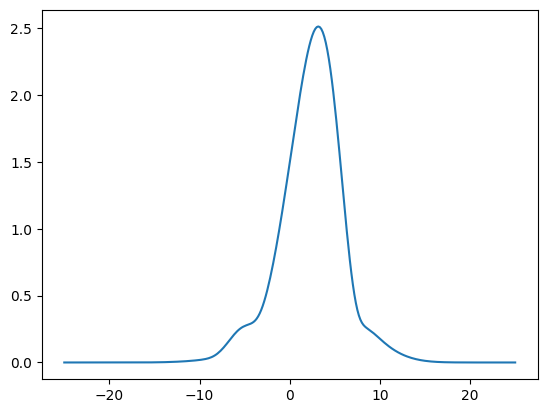

In [ ]:
plt.plot(xGrid,np.abs(Vsol[1,:,nH]))

# Projection and final integrals

$u_r^\dagger({\bf q})$ and $v_r^\dagger(-{\bf q})$ for projecting with $(U_{\rm in}[r,{\bf q}]|$ and $(V_{\rm in}[r,-{\bf q}]|$. $r=1,2$ is a spin index, which is irrelevant for the 2D spinors.

In [8]:
uFFT1=[uab(K1,-K2,K3,a,1)*np.exp(1j*np.sqrt(1+K1*K1+K2*K2+K3*K3)*tin) for a in range(gDim)]
vFFT1=[vab(-K1,K2,-K3,a,1)*np.exp(-1j*np.sqrt(1+K1*K1+K2*K2+K3*K3)*tin) for a in range(gDim)]

uFFT2=[uab(K1,-K2,K3,a,2)*np.exp(1j*np.sqrt(1+K1*K1+K2*K2+K3*K3)*tin) for a in range(gDim)]
vFFT2=[vab(-K1,K2,-K3,a,2)*np.exp(-1j*np.sqrt(1+K1*K1+K2*K2+K3*K3)*tin) for a in range(gDim)]

Project $\psi_\text{scat.}=\Delta U$ and $\psi_\text{scat.}=\Delta V$ onto in states: $(U_{\rm in}|\Delta U)$, $(V_{\rm in}|\Delta U)$, $(U_{\rm in}|\Delta V)$ and $(V_{\rm in}|\Delta V)$. We can compute these using FFT. First, $f({\bf q}):=(U_{\rm in}[{\bf q}]|\Delta U)=U_{\rm in}^\dagger(r,{\bf q},t_{\rm in},{\bf x}\to 0)\Delta U({\bf q})$. Then, for the next step in the calculation of $N_1$, we express $f({\bf q})=:\int d^3{\bf x}\;e^{i{\bf q}\cdot{\bf x}}f({\bf x})$. U1U etc. below corresponds to $f({\bf x})$.

In [9]:
def projectU():
  global U1U, V1U, U2U, V2U

  f=[np.pad(Usol[a],nPad) for a in range(gDim)]
  f=[np.fft.ifftn(f[a]) for a in range(gDim)]

  U1U=sum(uFFT1[a]*f[a] for a in range(gDim))
  U1U=np.fft.fftn(U1U)
  U1U=U1U[unPad]

  U2U=sum(uFFT2[a]*f[a] for a in range(gDim))
  U2U=np.fft.fftn(U2U)
  U2U=U2U[unPad]

  V1U=sum(vFFT1[a]*f[a] for a in range(gDim))
  V1U=np.fft.fftn(V1U)
  V1U=V1U[unPad]

  V2U=sum(vFFT2[a]*f[a] for a in range(gDim))
  V2U=np.fft.fftn(V2U)
  V2U=V2U[unPad]

def projectV():
  global U1V, V1V, U2V, V2V

  f=[np.pad(Vsol[a],nPad) for a in range(gDim)]
  f=[np.fft.ifftn(f[a]) for a in range(gDim)]

  U1V=sum(uFFT1[a]*f[a] for a in range(gDim))
  U1V=np.fft.fftn(U1V)
  U1V=U1V[unPad]

  U2V=sum(uFFT2[a]*f[a] for a in range(gDim))
  U2V=np.fft.fftn(U2V)
  U2V=U2V[unPad]

  V1V=sum(vFFT1[a]*f[a] for a in range(gDim))
  V1V=np.fft.fftn(V1V)
  V1V=V1V[unPad]

  V2V=sum(vFFT2[a]*f[a] for a in range(gDim))
  V2V=np.fft.fftn(V2V)
  V2V=V2V[unPad]

Solve the Dirac equation, project onto in states, and then perform the integrals in

\begin{equation}
N_{1\text{vers1}}=\big|{}_m(U_\infty|\Delta V)_n+{}_m(\Delta U|U_\infty)(U_\infty|\Delta V)_n\big|_{t=t_{\rm in}}^2
\end{equation}
\begin{equation}
N_{1\text{vers2}}=\big|{}_m(\Delta U|V_\infty)_n+{}_m(\Delta U|V_\infty)(V_\infty|\Delta V)_n\big|_{t=t_{\rm in}}^2
\end{equation}

We compute the integrals over ${\bf q}$ using
\begin{equation}
\int\frac{d^3{\bf q}}{(2\pi)^3}f^\dagger({\bf q})g({\bf q})=\int d^3{\bf x}f^\dagger({\bf x})g({\bf x})
\end{equation}
where $f$ and $g$ are the functions calculated with projectU() and projectV().
We should find $N_{1\text{vers1}}=N_{1\text{vers2}}$ to within the numerical precision.

In [10]:
def finalInts():

  global N1vers1, N1vers2, terms1, terms2

  projectU()
  projectV()

  UU1U1V=np.conjugate(U1U)*U1V
  UU2U2V=np.conjugate(U2U)*U2V
  UV1V1V=np.conjugate(V1U)*V1V
  UV2V2V=np.conjugate(V2U)*V2V
  U1Vdelta=np.exp(1j*(p1*X+p2*Y+p3*Z))*U1V
  U2Vdelta=np.exp(1j*(p1*X+p2*Y+p3*Z))*U2V
  V1Udelta=np.exp(1j*(pp1*X+pp2*Y+pp3*Z))*np.conjugate(V1U)
  V2Udelta=np.exp(1j*(pp1*X+pp2*Y+pp3*Z))*np.conjugate(V2U)

  for i in range(xDim):
    UU1U1V=simpson(UU1U1V,xGrid)
    UU2U2V=simpson(UU2U2V,xGrid)
    U1Vdelta=simpson(U1Vdelta,xGrid)
    U2Vdelta=simpson(U2Vdelta,xGrid)

    UV1V1V=simpson(UV1V1V,xGrid)
    UV2V2V=simpson(UV2V2V,xGrid)
    V1Udelta=simpson(V1Udelta,xGrid)
    V2Udelta=simpson(V2Udelta,xGrid)

  terms1=[U1Vdelta,U2Vdelta,UU1U1V,UU2U2V]
  terms2=[V1Udelta,V2Udelta,UV1V1V,UV2V2V]

  if uSpin==1:
    delta1=U1Vdelta
  elif uSpin==2:
    delta1=U2Vdelta

  if vSpin==1:
    delta2=V1Udelta
  elif vSpin==2:
    delta2=V2Udelta

  if gDim==4:
    secondSpin=1
  else:
    secondSpin=0

  N1vers1=np.abs(delta1+UU1U1V+secondSpin*UU2U2V)**2
  N1vers2=np.abs(delta2+UV1V1V+secondSpin*UV2V2V)**2

In [11]:
def doAll():
  global Usol, Vsol, N1vers1, N1vers2, terms1, terms2

  UdPsi=makeDer(p1,p2,p3,uSpin,1)
  term=ODETerm(UdPsi)
  solutionU = diffeqsolve(term,solver,t0=tout,t1=tin,dt0=-1e-2,y0=psiOut,
    stepsize_controller=controller)

  Usolr,Usoli=np.split(solutionU.ys[0],2)
  Usol=Usolr+1j*Usoli
  Usol=Usol.reshape(Ushape)

  VdPsi=makeDer(pp1,pp2,pp3,vSpin,-1)
  term=ODETerm(VdPsi)
  solutionV = diffeqsolve(term,solver,t0=tout,t1=tin,dt0=-1e-2,y0=psiOut,
    stepsize_controller=controller)

  Vsolr,Vsoli=np.split(solutionV.ys[0],2)
  Vsol=Vsolr+1j*Vsoli
  Vsol=Vsol.reshape(Ushape)

  finalInts()

# Check definitions for 1+1 and 2+1

In [12]:
solver = Dopri5()
controller = PIDController(rtol=1e-5, atol=1e-10)

In [13]:
p1=-.35; p2=0; p3=0; p0=np.sqrt(1+p1*p1+p2*p2+p3*p3)
pp1=-p1; pp2=-p2; pp3=-p3; pp0=np.sqrt(1+pp1*pp1+pp2*pp2+pp3*pp3)
uSpin=1; vSpin=1;

In [14]:
doAll()

In [ ]:
#1+1
[N1vers1,N1vers2,N1vers1/N1vers2-1]

[Array(0.00024685, dtype=float32),
 Array(0.00024697, dtype=float32),
 Array(-0.00049293, dtype=float32)]

OK, N1vers1 and N1vers2 agree. Could also check that different values of tin give the same result.

In [ ]:
check=2*N1vers1/(2*np.pi)**4

In [ ]:
check/(3.16865e-7)-1

Array(-0.00030756, dtype=float32)

In [ ]:
#2+1
[N1vers1,N1vers2,N1vers1/N1vers2-1]

[Array(0.0021904, dtype=float32),
 Array(0.00219009, dtype=float32),
 Array(0.00014007, dtype=float32)]

# 1+1

Check that dx and dk are small enough, and that kMax is large enough.

In [ ]:
[kappa*dx,dk,kMax]

[0.09999999999999999, 0.06912195057403286, 10.437414536678963]

Make a 1D cross section in the momentum space:

In [ ]:
pmin=0.; pmax=1.; dp=(pmax-pmin)/20.
pList=np.arange(dp,pmax+dp,dp)

In [ ]:
tab1=[0 for _ in pList]
tab2=[0 for _ in pList]

In [ ]:
ip=0
for p in tqdm(pList):
  p1=-p; pp1=-p1;
  doAll()
  tab1[ip]=N1vers1
  tab2[ip]=N1vers2
  ip=ip+1

100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


Each step takes 3-4 seconds on the CPU

In [ ]:
tab1=np.array(tab1)
tab2=np.array(tab2)

In [ ]:
tab1

Array([1.6729886e-05, 6.1961495e-05, 1.2275833e-04, 1.8282066e-04,
       2.2782259e-04, 2.4951628e-04, 2.4688616e-04, 2.2463863e-04,
       1.9060161e-04, 1.5265371e-04, 1.1675311e-04, 8.6284177e-05,
       6.2342959e-05, 4.4541754e-05, 3.1645195e-05, 2.2431670e-05,
       1.5872851e-05, 1.1149386e-05, 7.7541345e-06, 5.2850060e-06],      dtype=float32)

In [ ]:
tab1/tab2-1

Array([-1.5079975e-04, -4.9179792e-04, -3.1143427e-04,  2.8848648e-05,
        1.3077259e-04, -2.0515919e-04, -3.0398369e-06,  1.0204315e-04,
       -2.8151274e-04,  1.5270710e-04, -5.0365925e-05,  5.4121017e-05,
        4.9936771e-04,  5.6099892e-04,  6.1535835e-04, -3.1840801e-04,
       -1.3291836e-05, -1.8979311e-03, -2.3466349e-04, -3.0109286e-03],      dtype=float32)

Make a smooth interpolation function for plotting:

In [ ]:
inter1=make_interp_spline(pList,2*tab1/((2*np.pi)**4), k=3)
inter2=make_interp_spline(pList,2*tab2/((2*np.pi)**4), k=3)

pDense=np.linspace(pList.min(), pList.max(), 100)
dense1=inter1(pDense)
dense2=inter2(pDense)

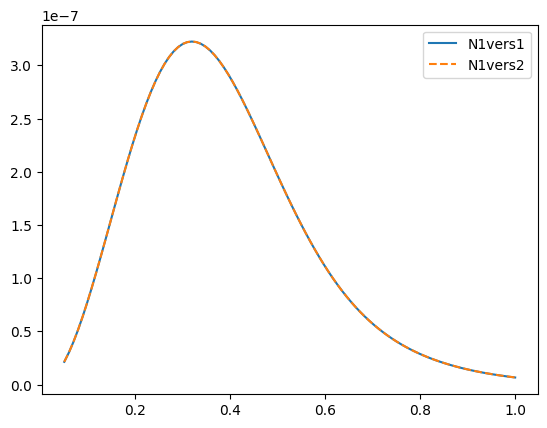

In [ ]:
plt.plot(pDense,dense1,label='N1vers1')
plt.plot(pDense,dense2,linestyle="--",label='N1vers2')
plt.legend()
plt.show()

In [ ]:
mathematicaOnCPU=[[0.03, 7.8388e-9], [0.06, 3.0617e-8], [0.09, 6.5582e-8], [0.12, \
1.095e-7], [0.15, 1.5766e-7], [0.18, 2.0507e-7], [0.21, 2.4832e-7], \
[0.24, 2.8291e-7], [0.27, 3.0737e-7], [0.3, 3.2049e-7], [0.33, \
3.2158e-7], [0.36, 3.1299e-7], [0.39, 2.9572e-7], [0.42, 2.7208e-7], \
[0.45, 2.448e-7], [0.48, 2.1548e-7], [0.51, 1.8636e-7], [0.54, \
1.5865e-7], [0.57, 1.3324e-7], [0.6, 1.1076e-7], [0.63, 9.1327e-8], \
[0.66, 7.4872e-8], [0.69, 6.1144e-8], [0.72, 4.9881e-8], [0.75, \
4.0607e-8], [0.78, 3.3048e-8], [0.81, 2.6914e-8], [0.84, 2.1849e-8], \
[0.87, 1.774e-8], [0.9, 1.4339e-8], [0.93, 1.1531e-8], [0.96, \
9.2499e-9], [0.99, 7.3509e-9], [1.02, 5.8139e-9], [1.05, 4.5619e-9], \
[1.08, 3.5458e-9], [1.11, 2.7448e-9], [1.14, 2.1024e-9], [1.17, \
1.5988e-9], [1.2, 1.2106e-9]]

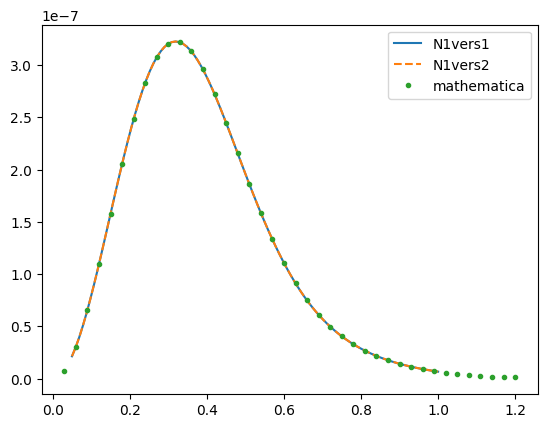

In [ ]:
plt.plot(pDense,dense1,label='N1vers1')
plt.plot(pDense,dense2,linestyle="--",label='N1vers2')
plt.plot(*zip(*mathematicaOnCPU),marker='.',linestyle="None",label='mathematica')
plt.legend()
plt.show()

# 2+1

In [ ]:
pmin=0.; pmax=1.; dp=(pmax-pmin)/20.
pList=np.arange(dp,pmax+dp,dp)

In [ ]:
tab1=[0 for _ in pList]
tab2=[0 for _ in pList]

In [ ]:
ip=0
for p in tqdm(pList):
  p1=-p; pp1=-p1;
  doAll()
  tab1[ip]=N1vers1
  tab2[ip]=N1vers2
  ip=ip+1

100%|██████████| 20/20 [01:25<00:00,  4.27s/it]


Each step takes about 4 seconds on the T4 GPU

Using Mathematica on a laptop CPU, each point in the results below (mathematicaOnCPU) took about 12-14 minutes. Thus, GPU is much faster!

In [ ]:
tab1

Array([1.4625232e-04, 5.4261339e-04, 1.0774472e-03, 1.6093208e-03,
       2.0122125e-03, 2.2101812e-03, 2.1903885e-03, 1.9905877e-03,
       1.6781884e-03, 1.3244102e-03, 9.8537095e-04, 6.9655036e-04,
       4.7129221e-04, 3.0779897e-04, 1.9579030e-04, 1.2244930e-04,
       7.5973323e-05, 4.7059788e-05, 2.9233901e-05, 1.8131210e-05],      dtype=float32)

In [ ]:
tab1=np.array(tab1)
tab2=np.array(tab2)

In [ ]:
tab1/tab2-1

Array([ 9.52780247e-03,  5.53882122e-03,  1.92689896e-03,  2.95042992e-04,
        2.27808952e-04,  2.38537788e-04,  1.11460686e-04, -1.37448311e-04,
       -3.25322151e-04, -8.33272934e-05, -4.25398350e-04, -9.39846039e-04,
       -1.30164623e-03, -3.54409218e-04,  1.45196915e-04,  6.92009926e-04,
        1.38521194e-04, -7.15255737e-07,  2.20656395e-04, -1.89751387e-03],      dtype=float32)

Make a smooth interpolation function for plotting:

In [ ]:
inter1=make_interp_spline(pList,2*tab1/((2*np.pi)**5), k=3)
inter2=make_interp_spline(pList,2*tab2/((2*np.pi)**5), k=3)

pDense=np.linspace(pList.min(), pList.max(), 100)
dense1=inter1(pDense)
dense2=inter2(pDense)

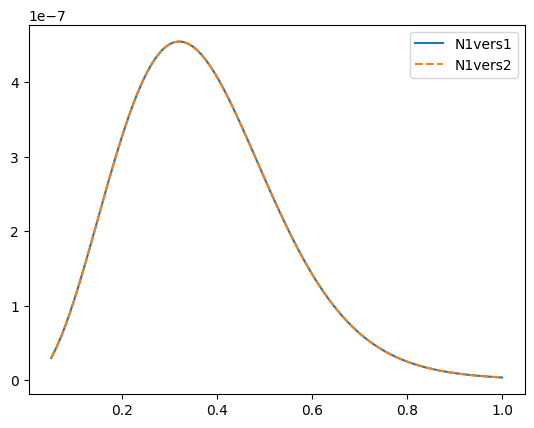

In [ ]:
plt.plot(pDense,dense1,label='N1vers1')
plt.plot(pDense,dense2,linestyle="--",label='N1vers2')
plt.legend()
plt.show()

In [ ]:
mathematicaOnCPU=[[0.05, 2.9864e-8], [0.1, 1.1083e-7], [0.15, 2.2002e-7], [0.2, \
3.2863e-7], [0.25, 4.1097e-7], [0.3, 4.5147e-7], [0.35, 4.4733e-7], \
[0.4, 4.0663e-7], [0.45, 3.428e-7], [0.5, 2.705e-7], [0.55, \
2.0127e-7], [0.6, 1.423e-7], [0.65, 9.6278e-8], [0.7, 6.287e-8], \
[0.75, 3.9987e-8], [0.8, 2.5016e-8], [0.85, 1.5521e-8], [0.9, \
9.6208e-9], [0.95, 5.9733e-9], [1., 3.7148e-9]]

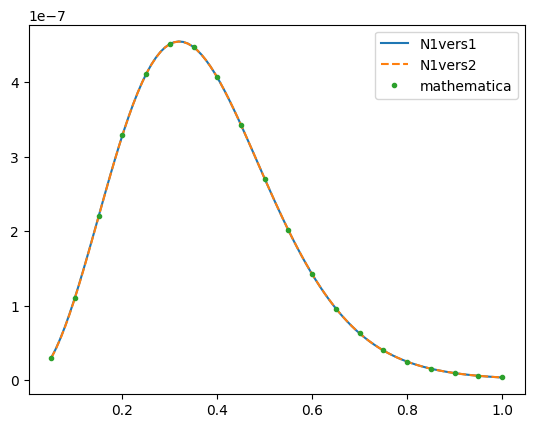

In [ ]:
plt.plot(pDense,dense1,label='N1vers1')
plt.plot(pDense,dense2,linestyle="--",label='N1vers2')
plt.plot(*zip(*mathematicaOnCPU),marker='.',linestyle="None",label='mathematica')
plt.legend()
plt.show()

# Test precision for 2+1

In [ ]:
xb=25; nx=501; nk=1501
tin=-12; tout=11

In [ ]:
[kappa*dx,dk,kMax]

[0.03333333333333333, 0.041859995384274394, 31.394996538205795]

In [ ]:
#2+1
[N1vers1,N1vers2,N1vers1/N1vers2-1]

[Array(0.00219026, dtype=float32),
 Array(0.0021901, dtype=float32),
 Array(7.2956085e-05, dtype=float32)]

In [ ]:
previous=0.0021904

In [ ]:
previous/0.00219026-1

6.391935204042021e-05

# 3+1

In [12]:
solver = Dopri5()
controller = PIDController(rtol=1e-5, atol=1e-10)

In [13]:
p1=0; p2=0; p3=-.35; p0=np.sqrt(1+p1*p1+p2*p2+p3*p3)
pp1=-p1; pp2=-p2; pp3=-p3; pp0=np.sqrt(1+pp1*pp1+pp2*pp2+pp3*pp3)
uSpin=1; vSpin=1;

In [ ]:
doAll()

In [ ]:
[N1vers1,N1vers2,N1vers1/N1vers2-1]

[Array(0.01745716, dtype=float32),
 Array(0.01746742, dtype=float32),
 Array(-0.00058717, dtype=float32)]

The above took ~4 minutes.

In [ ]:
pmin=0.; pmax=1.; dp=(pmax-pmin)/20.
pList=np.arange(dp,pmax+dp,dp)

In [ ]:
tab1=[0 for _ in pList]
tab2=[0 for _ in pList]

In [ ]:
ip=0
for p in tqdm(pList):
  p3=-p; pp3=-p3;
  doAll()
  tab1[ip]=N1vers1
  tab2[ip]=N1vers2
  print([p,N1vers1,N1vers2])
  ip=ip+1

  5%|▌         | 1/20 [04:00<1:16:18, 240.98s/it]

[Array(0.05, dtype=float32), Array(0.00116338, dtype=float32), Array(0.00116138, dtype=float32)]


 10%|█         | 2/20 [08:00<1:11:59, 239.98s/it]

[Array(0.1, dtype=float32), Array(0.00431084, dtype=float32), Array(0.00430897, dtype=float32)]


 15%|█▌        | 3/20 [11:59<1:07:52, 239.53s/it]

[Array(0.15, dtype=float32), Array(0.00857101, dtype=float32), Array(0.0085716, dtype=float32)]


 20%|██        | 4/20 [15:55<1:03:34, 238.42s/it]

[Array(0.2, dtype=float32), Array(0.01280674, dtype=float32), Array(0.01279864, dtype=float32)]


 25%|██▌       | 5/20 [19:56<59:48, 239.24s/it]  

[Array(0.25, dtype=float32), Array(0.01601812, dtype=float32), Array(0.01601806, dtype=float32)]


 30%|███       | 6/20 [23:55<55:49, 239.26s/it]

[Array(0.3, dtype=float32), Array(0.01761354, dtype=float32), Array(0.01761035, dtype=float32)]


 35%|███▌      | 7/20 [27:54<51:47, 239.05s/it]

[Array(0.35000002, dtype=float32), Array(0.01745871, dtype=float32), Array(0.0174678, dtype=float32)]


 40%|████      | 8/20 [31:53<47:47, 239.00s/it]

[Array(0.4, dtype=float32), Array(0.01588265, dtype=float32), Array(0.01588578, dtype=float32)]


 45%|████▌     | 9/20 [35:52<43:47, 238.91s/it]

[Array(0.45000002, dtype=float32), Array(0.01339198, dtype=float32), Array(0.01339769, dtype=float32)]


 50%|█████     | 10/20 [39:50<39:48, 238.87s/it]

[Array(0.5, dtype=float32), Array(0.01055042, dtype=float32), Array(0.010554, dtype=float32)]


 55%|█████▌    | 11/20 [43:50<35:51, 239.06s/it]

[Array(0.55, dtype=float32), Array(0.00782157, dtype=float32), Array(0.00782002, dtype=float32)]


 60%|██████    | 12/20 [47:48<31:51, 238.89s/it]

[Array(0.6, dtype=float32), Array(0.00547773, dtype=float32), Array(0.00548163, dtype=float32)]


 65%|██████▌   | 13/20 [51:48<27:52, 238.94s/it]

[Array(0.65000004, dtype=float32), Array(0.00365165, dtype=float32), Array(0.00365158, dtype=float32)]


 70%|███████   | 14/20 [55:47<23:54, 239.02s/it]

[Array(0.70000005, dtype=float32), Array(0.00232051, dtype=float32), Array(0.00231758, dtype=float32)]


 75%|███████▌  | 15/20 [59:47<19:57, 239.51s/it]

[Array(0.75, dtype=float32), Array(0.00141744, dtype=float32), Array(0.00141352, dtype=float32)]


 80%|████████  | 16/20 [1:03:45<15:55, 238.85s/it]

[Array(0.8, dtype=float32), Array(0.00083536, dtype=float32), Array(0.00083087, dtype=float32)]


 85%|████████▌ | 17/20 [1:07:42<11:55, 238.33s/it]

[Array(0.85, dtype=float32), Array(0.00047824, dtype=float32), Array(0.00047785, dtype=float32)]


 90%|█████████ | 18/20 [1:11:38<07:55, 237.64s/it]

[Array(0.90000004, dtype=float32), Array(0.00026811, dtype=float32), Array(0.00027072, dtype=float32)]


 95%|█████████▌| 19/20 [1:15:36<03:57, 237.70s/it]

[Array(0.95000005, dtype=float32), Array(0.00014861, dtype=float32), Array(0.00014985, dtype=float32)]


100%|██████████| 20/20 [1:19:38<00:00, 238.94s/it]

[Array(1., dtype=float32), Array(8.161473e-05, dtype=float32), Array(8.304099e-05, dtype=float32)]


Each step took about 4 minutes on the A100 GPU

In [ ]:
tab1

[Array(0.00116338, dtype=float32),
 Array(0.00431084, dtype=float32),
 Array(0.00857101, dtype=float32),
 Array(0.01280674, dtype=float32),
 Array(0.01601812, dtype=float32),
 Array(0.01761354, dtype=float32),
 Array(0.01745871, dtype=float32),
 Array(0.01588265, dtype=float32),
 Array(0.01339198, dtype=float32),
 Array(0.01055042, dtype=float32),
 Array(0.00782157, dtype=float32),
 Array(0.00547773, dtype=float32),
 Array(0.00365165, dtype=float32),
 Array(0.00232051, dtype=float32),
 Array(0.00141744, dtype=float32),
 Array(0.00083536, dtype=float32),
 Array(0.00047824, dtype=float32),
 Array(0.00026811, dtype=float32),
 Array(0.00014861, dtype=float32),
 Array(8.161473e-05, dtype=float32)]

In [ ]:
tab2

[Array(0.00116138, dtype=float32),
 Array(0.00430897, dtype=float32),
 Array(0.0085716, dtype=float32),
 Array(0.01279864, dtype=float32),
 Array(0.01601806, dtype=float32),
 Array(0.01761035, dtype=float32),
 Array(0.0174678, dtype=float32),
 Array(0.01588578, dtype=float32),
 Array(0.01339769, dtype=float32),
 Array(0.010554, dtype=float32),
 Array(0.00782002, dtype=float32),
 Array(0.00548163, dtype=float32),
 Array(0.00365158, dtype=float32),
 Array(0.00231758, dtype=float32),
 Array(0.00141352, dtype=float32),
 Array(0.00083087, dtype=float32),
 Array(0.00047785, dtype=float32),
 Array(0.00027072, dtype=float32),
 Array(0.00014985, dtype=float32),
 Array(8.304099e-05, dtype=float32)]

In [ ]:
tab1=np.array(tab1)
tab2=np.array(tab2)

In [ ]:
tab1/tab2-1

Array([ 1.7179251e-03,  4.3272972e-04, -6.8247318e-05,  6.3335896e-04,
        3.8146973e-06,  1.8155575e-04, -5.2016973e-04, -1.9681454e-04,
       -4.2593479e-04, -3.3968687e-04,  1.9788742e-04, -7.1126223e-04,
        1.8596649e-05,  1.2643337e-03,  2.7698278e-03,  5.4121017e-03,
        8.2039833e-04, -9.6198916e-03, -8.3018541e-03, -1.7175317e-02],      dtype=float32)

In [ ]:
inter1=make_interp_spline(pList,tab1, k=3)
inter2=make_interp_spline(pList,tab2, k=3)

pDense=np.linspace(pList.min(), pList.max(), 100)
dense1=inter1(pDense)
dense2=inter2(pDense)

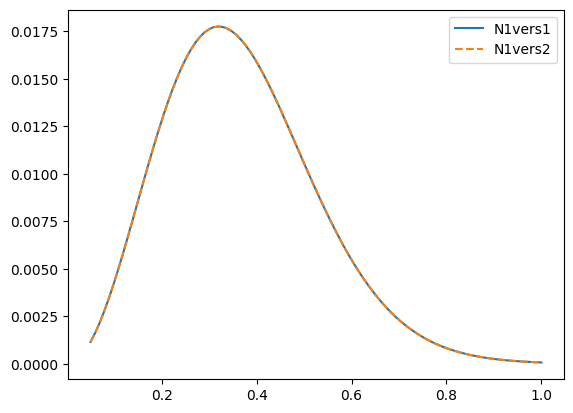

In [ ]:
plt.plot(pDense,dense1,label='N1vers1')
plt.plot(pDense,dense2,linestyle="--",label='N1vers2')
plt.legend()
plt.show()

We have no CPU results to compare with here.

# Test precision for 3+1

In [12]:
xb=25; nx=101; nk=201
tin=-12; tout=11

In [19]:
[kappa*dx,dk,kMax]

[0.16666666666666666, 0.06251925678785658, 6.251925678785658]

In [20]:
solver = Dopri5()
controller = PIDController(rtol=1e-5, atol=1e-10)

In [21]:
p1=0; p2=0; p3=-.35; p0=np.sqrt(1+p1*p1+p2*p2+p3*p3)
pp1=-p1; pp2=-p2; pp3=-p3; pp0=np.sqrt(1+pp1*pp1+pp2*pp2+pp3*pp3)
uSpin=1; vSpin=1;

In [ ]:
doAll()

this took ~1 minute

In [ ]:
[N1vers1,N1vers2,N1vers1/N1vers2-1]

[Array(0.01747012, dtype=float32),
 Array(0.01746202, dtype=float32),
 Array(0.00046408, dtype=float32)]

In [ ]:
previous1=0.01745716
previous2=0.01746742

In [ ]:
[N1vers1/previous1-1,N1vers2/previous2-1,previous1/previous2-1]

[Array(0.00074267, dtype=float32),
 Array(-0.00030923, dtype=float32),
 -0.0005873792466203342]

OK, could have used fewer points in the previous run.

# Checking spin definitions

In [ ]:
p1=-.35; p2=.1; p3=.2; p0=np.sqrt(1+p1*p1+p2*p2+p3*p3)
pp1=-p1; pp2=-p2; pp3=-p3; pp0=np.sqrt(1+pp1*pp1+pp2*pp2+pp3*pp3)

In [ ]:
ut1=np.array([uab(p1,p2,p3,a,1) for a in range(gDim)])
ut2=np.array([uab(p1,p2,p3,a,2) for a in range(gDim)])
vt1=np.array([vab(pp1,pp2,pp3,a,1) for a in range(gDim)])
vt2=np.array([vab(pp1,pp2,pp3,a,2) for a in range(gDim)])

ut=[ut1,ut2,vt1,vt2]

In [ ]:
for i in range(4):
  for j in range(4):
    if i==j:
      print(np.abs(np.conjugate(ut[i])@ut[j]-1))
    else:
      print(np.abs(np.conjugate(ut[i])@ut[j]))

In [ ]:
np.abs((p0*g0+p1*g1+p2*g2+p3*g3-id)@ut2)

Array([0.0000000e+00, 1.4901161e-08, 4.3215342e-10, 2.9802322e-08],      dtype=float32)

In [ ]:
np.abs((pp0*g0+pp1*g1+pp2*g2+pp3*g3+id)@vt1)

Array([0.000000e+00, 5.962339e-08, 7.450581e-09, 0.000000e+00], dtype=float32)